# Import

In [1]:
# investigating hyperspectral compressed sensing results
import numpy as np
from matplotlib import pyplot as plt
#import hyperspy.api as hs
from PIL import Image
import matplotlib
from os import walk
from scipy.linalg import hadamard
import pandas as pd
from scipy.optimize import curve_fit
import scipy.io
import h5py
import natsort

%config Completer.use_jedi = False
%matplotlib inline

C:\Users\grlew\miniconda3\envs\sandbox\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def plot_roi(datacube,i=0,j=0,box_width=10,axs=None,return_roi=False,plot=True,axis_off = True,ylim=False,n_bands=63):
    """
    i = column index
    j = row index
    """
    i = i-int(box_width/2)
    j = j-int(box_width/2)
    
    # Get average spectrum at roi
    roi = datacube[j:j+box_width,i:i+box_width,:]
    avg = np.mean(roi,axis=0)
    avg = np.mean(avg,axis=0)
        
    if plot == True:
        if axs == None:
            fig,axs = plt.subplots(ncols=2,figsize=(8,4))

        # Plot intensity image
        axs[0].imshow(np.mean(datacube,axis=2),cmap='gray')
        # Plot ROI marker
        axs[0].plot([i,i,i+box_width,i+box_width,i],[j,j+box_width,j+box_width,j,j],'r-',markersize=15,markeredgewidth=2,alpha=.8)
        
        axs[0].set_title('Region of interest: (%i, %i) %ix%i' % (i,j,box_width,box_width))
        if axis_off == True:
            axs[0].axis('off')

        

        axs[1].plot(np.arange(1,n_bands+1),avg)
        axs[1].set_xlabel('Band number')
        axs[1].set_ylabel('Intensity')
        if type(ylim)!=type(False):
            axs[1].set_ylim(ylim)

        plt.tight_layout()
    
    if return_roi == True:
        return avg

def load_imstack(fpaths,roi=[0,100,0,100],n_bands=63, inverse=False):
    """ Given a list of filepaths, returns (imx,imy,n_bands) shape array """
    if inverse == False:
        meas = np.zeros((roi[1]-roi[0],roi[3]-roi[2],n_bands))
        for i,f in enumerate(fpaths):
            # load image
            im = np.array(Image.open(f).convert('L'))
            # crop image
            im = im[roi[0]:roi[1],roi[2]:roi[3]]
            # add to stack
            meas[:,:,i] = im

        return meas
    
    if inverse == True:
        meas = np.zeros((roi[1]-roi[0],roi[3]-roi[2],n_bands))
        inv = np.zeros((roi[1]-roi[0],roi[3]-roi[2],n_bands))
        for i,f in enumerate(fpaths):
            # load image
            im = np.array(Image.open(f).convert('L'))
            # crop image
            im = im[roi[0]:roi[1],roi[2]:roi[3]]
            # add to stack
            if i%2 == 0:
                meas[:,:,int(i/2)] = im
            if i%2 == 1:
                inv[:,:,int(i/2-.5)] = im
                
        return meas, inv

def reconstruct_normal(meas,bgs_avg, roi=[0,100,0,100], n_bands = 63):
    """ Given a set of Hadamard multiplexed measurements (imx,imy,n_bands) 
    in the correct order, returns a hyperspectral datacube """
    # flatten images in the image stacks
    meas_flat = np.reshape(meas,(np.shape(meas)[0]*np.shape(meas)[1],np.shape(meas)[2]))
    bgs_avg_flat = np.reshape(bgs_avg,(np.shape(meas)[0]*np.shape(meas)[1],1))
    
    # subtract background
    meas_norm_flat = meas_flat - bgs_avg_flat
    
    # load hadamard matrix
    # remove first row and also negative values
    sensing_mat = hadamard(n_bands+1)[1:,1:]
    sensing_mat = sensing_mat * (sensing_mat > 0)
    
    # reconstruct datacube: recon = H^-1 * meas
    cube_flat = (np.matmul(np.linalg.inv(sensing_mat),meas_norm_flat.T)).T
    
    # reshape
    cube = cube_flat.reshape((roi[1]-roi[0],roi[3]-roi[2],n_bands))
    
    return cube

def reconstruct_inverse(meas,inv,n_bands,roi):
    # flatten images in the image stacks
    meas_flat = np.reshape(meas,(np.shape(meas)[0]*np.shape(meas)[1],np.shape(meas)[2]))
    inv_flat = np.reshape(inv,(np.shape(meas)[0]*np.shape(meas)[1],np.shape(meas)[2]))

    # subtract background
    meas_norm_flat = (meas_flat - inv_flat)

    # shift negative values
    #meas_norm_flat = meas_norm_flat+abs(np.min(meas_norm_flat))

    # load hadamard matrix
    # remove first row and also negative values
    sensing_mat = hadamard(n_bands+1)[1:,1:]
    sensing_mat = sensing_mat * (sensing_mat > 0)

    # reconstruct datacube: recon = H^-1 * meas
    cube_flat = (np.matmul(np.linalg.inv(sensing_mat),meas_norm_flat.T)).T

    # reshape
    cube = cube_flat.reshape((roi[1]-roi[0],roi[3]-roi[2],n_bands))
    
    return cube

def get_fpaths_in_folder(folder):
    """ Folder should be ~ r'C:\path\\' 
    returns fpaths in alphabetical order """
    _, _, filenames = next(walk(folder))

    fpaths = []
    for f in filenames:
        fpaths.append(folder+f)
    
    return fpaths

def calibrate_wavelengths(nbands = 63, plot=True, lin_region=(50,175),fpath = r'C:\\Users\\grl31\\Dropbox (Cambridge University)\\INT CS\\trial\\trial 7 29-10-21\\\\FLMT018561_13-48-37-783.txt'):
    df = pd.read_csv(fpath,header=12,delimiter='\t')
    
    # extract the wavelengths
    xs = np.array(df.index.values[0])
    xs = xs[2:]
    xf = df.iloc[0][0]
    xs = np.append(xs,xf)
    np.shape(xs)
    
    size = np.shape(df.index.values)[0] # number of spectra acquired
    
    # extract the intensities for each spectra
    all_ys = []
    for i in range(size-1):
        ys = np.array(df.index.values[1+i])
        ys = ys[2:]
        yf = df.iloc[0][0]
        ys = np.append(ys,yf)
        ys = ys.astype(float)
        all_ys.append(ys)
    
    # assume first reading is ~ backround
    bg = all_ys[0]
    
    # find peak at each step
    xmaxs = []
    for ys in all_ys:
        imax = np.argmax(ys - bg)
        xmax = xs[imax]
        xmaxs.append(xmax)

    # extract linear region
    xmaxs_lin = xmaxs[lin_region[0]:lin_region[1]]
    
    # spectra were not sampled at exactly 1 per raster, figure out the oversampling ratio
    n = 0
    for i in range(len(xmaxs_lin)-1):
        if abs(xmaxs_lin[i] - xmaxs_lin[i+1]) < 0.5:
            n +=1

    count_ratio = len(xmaxs_lin)/(len(xmaxs_lin)-n)
    
    # fit straight line to linear region
    def f(x, A, B): # this is your 'straight line' y=f(x)
        return A*x + B

    xfit = np.arange(lin_region[0],lin_region[1])
    popt, pcov = curve_fit(f, xfit, xmaxs_lin) # your data x, y to fit
    
    # extrapolate over full space
    yfits = []
    #
    for x in np.arange(len(xmaxs)*count_ratio):
        yfit = f(x,popt[0],popt[1])
        yfits.append(yfit)
        
    # take a look
    plt.plot(xmaxs, '.-', alpha=.8, label = 'Calibration data')
    plt.plot(yfits,'-',alpha=1,linewidth=1,color='r',label='Linear fit')

    plt.xlabel('Spectra number',fontsize=15)
    plt.ylabel('Wavelength / nm',fontsize=15)
    plt.legend(fontsize=12)
    
    # calibrate
    nbands = 63 # resolution used in measurements
    wavelengths = np.linspace(np.max(yfits),np.min(yfits),num=63)
    
    return wavelengths

In [112]:
hadamard(64)

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1, -1,  1, ..., -1,  1, -1],
       [ 1,  1, -1, ...,  1, -1, -1],
       ...,
       [ 1, -1,  1, ..., -1,  1, -1],
       [ 1,  1, -1, ...,  1, -1, -1],
       [ 1, -1, -1, ..., -1, -1,  1]])

# Load CS data

In [3]:
folder = r'C:\Users\grlew\Dropbox (Cambridge University)\INT CS\trial\trial 7 29-10-21\1000 ms inv\\'
all_fpaths = get_fpaths_in_folder(folder)


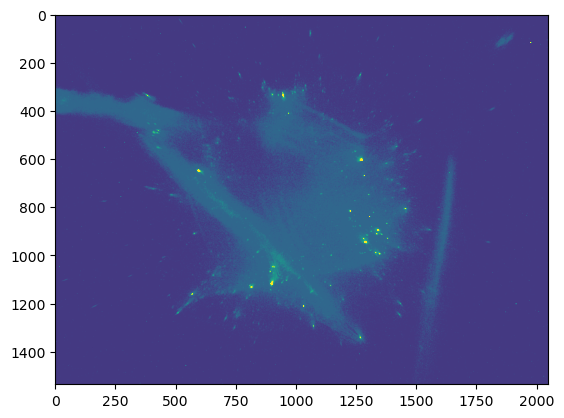

In [116]:
plt.imshow(imcs,vmax=20)

(-0.5, 99.5, 99.5, -0.5)

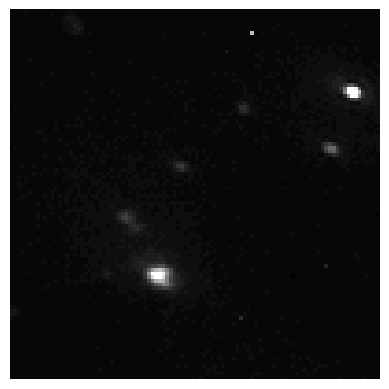

In [111]:
# check roi
roi = [875,975,1250,1350]
f=all_fpaths[30]
imcs = np.array(Image.open(f).convert('L'))
# crop image
im = imcs[roi[0]:roi[1],roi[2]:roi[3]]

plt.imshow(im,vmax=50,cmap='gray')
#plt.colorbar()
plt.axis('off')

In [10]:
meas,inv = load_imstack(all_fpaths,roi=roi,inverse=True)

In [11]:
cube = reconstruct_inverse(meas,inv,63,roi)

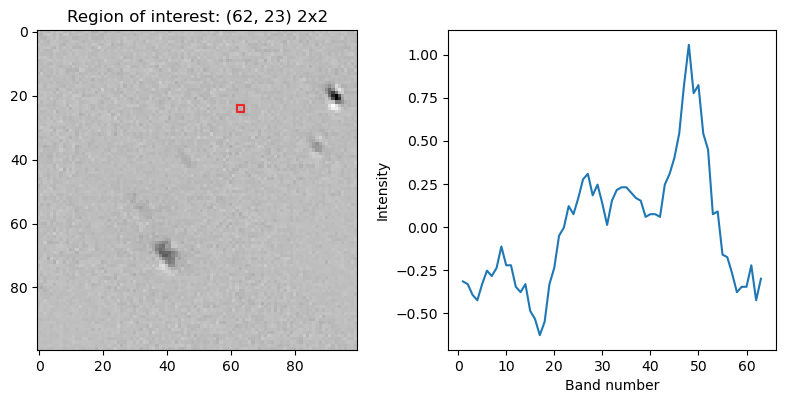

In [91]:
#d1 = plot_roi(cube,i=30,j=55,box_width=3,axis_off=False,return_roi=True)
#d2 = plot_roi(cube,i=46,j=40,box_width=2,axis_off=False,return_roi=True)
d3 = plot_roi(cube,i=63,j=24,box_width=2,axis_off=False,return_roi=True)

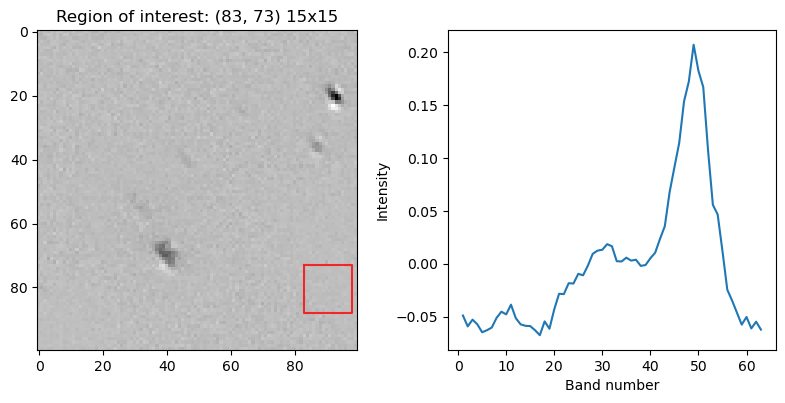

In [60]:
lamp = plot_roi(cube,i=90,j=80,box_width=15,axis_off=False,return_roi=True)

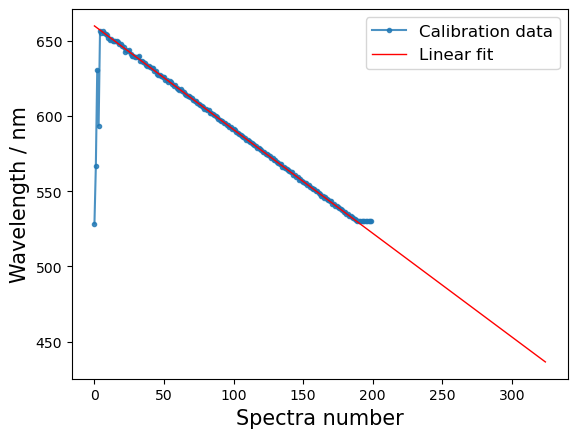

In [20]:
wavelengths = calibrate_wavelengths(fpath=r"C:\Users\grlew\Dropbox (Cambridge University)\INT CS\trial\trial 7 29-10-21\FLMT018561_13-48-37-783.txt")

Text(0.5, 0, 'Wavelength / nm')

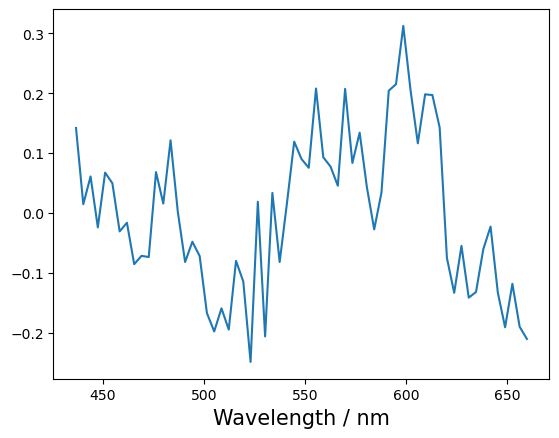

In [62]:
plt.plot(wavelengths,d-lamp*4)
plt.xlabel('Wavelength / nm',fontsize=15)

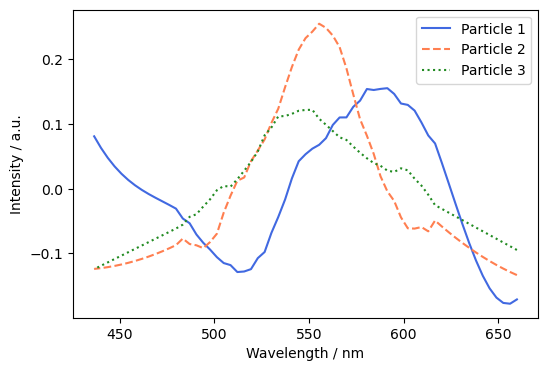

In [107]:
from scipy.signal import savgol_filter
box,order=25,3

plt.figure(figsize=(6,4))

yhat = savgol_filter(d-lamp*4, box, order)
xhat = savgol_filter(wavelengths, box, order)
plt.plot(xhat,yhat,'-',color='royalblue')
plt.plot(xhat2,yhat2,'--',color='coral')
plt.plot(xhat3,yhat3,':',color='forestgreen')
plt.xlabel('Wavelength / nm')
plt.ylabel('Intensity / a.u.')

plt.legend(['Particle 1','Particle 2','Particle 3'])

In [25]:
df = pd.read_csv(r"C:\Users\grlew\Dropbox (Cambridge University)\INT CS\trial\trial 7 29-10-21\FLMT018561_13-48-37-783.txt",header=12,delimiter='\t')

In [27]:
# extract the wavelengths
xs = np.array(df.index.values[0])
xs = xs[2:]
xf = df.iloc[0][0]
xs = np.append(xs,xf)
np.shape(xs)

size = np.shape(df.index.values)[0] # number of spectra acquired

# extract the intensities for each spectra
all_ys = []
for i in range(size-1):
    ys = np.array(df.index.values[1+i])
    ys = ys[2:]
    yf = df.iloc[0][0]
    ys = np.append(ys,yf)
    ys = ys.astype(float)
    all_ys.append(ys)

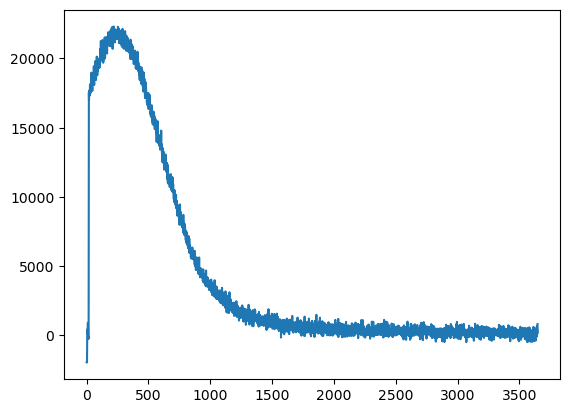

In [31]:
plt.plot(np.max(all_ys,axis=0))

# Load regular data

In [128]:
folder = r'C:\Users\grlew\Dropbox (Cambridge University)\INT CS\Regular HS\21-11-16\Processed\\'
namec = r'DataCube.mat'
namew = r'Wavelength.mat'

wls = scipy.io.loadmat(folder+namew)['Wavelength'].T
datacube = h5py.File(folder+namec).get('DataCube')


In [178]:
datacube = np.transpose(datacube)

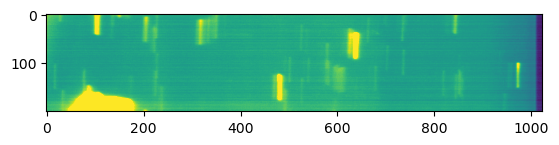

In [141]:
im = np.mean(datacube[:,:,:],axis=0)

plt.imshow(im[:,:],vmax=0.0008)

In [152]:
np.max(datacube)

0.057087506364010984

ValueError: x and y must have same first dimension, but have shapes (1023, 1) and (300,)

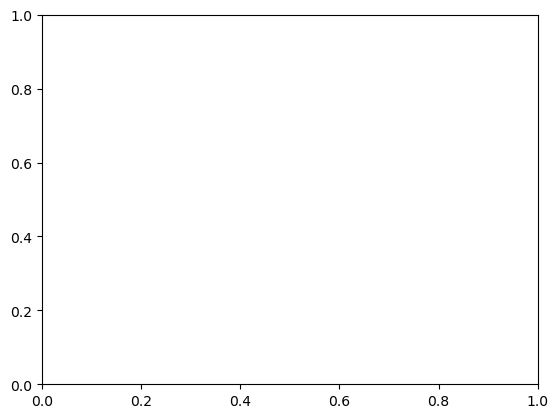

In [188]:
plt.plot(wls,datacube[190,100,500:800])
np.shape(datacube)

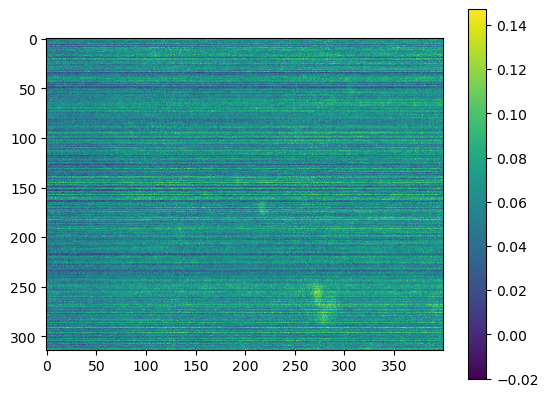

In [47]:
plt.imshow(im[:,400:800])
plt.colorbar()

In [153]:
folder = r'C:\Users\grlew\Dropbox (Cambridge University)\INT CS\Regular HS\21-11-16\\'
all_fpaths = get_fpaths_in_folder(folder)
fpaths = []
for f in all_fpaths:
    if 'AuDec1-1s' in f.split('\\')[-1] and 'csv' in f.split('\\')[-1]:
        fpaths.append(f)
fpaths = natsort.natsorted(fpaths)

In [154]:
cube = []
for f in fpaths:
    df = pd.read_csv(f,skiprows=1,index_col=0)
    cube.append(np.array(df))

In [155]:
dark  = pd.read_csv(r"C:\Users\grlew\Dropbox (Cambridge University)\INT CS\Regular HS\21-11-16\AuDec = lampDARK  002.csv",skiprows=1,index_col=0)
light = pd.read_csv(r"C:\Users\grlew\Dropbox (Cambridge University)\INT CS\Regular HS\21-11-16\AuDec = lamplight  001.csv",skiprows=1,index_col=0)

In [160]:
np.shape(dark)

(1024, 1024)

In [161]:
corrected = (np.mean(np.array(cube),axis=2)-dark)/(light-dark)

ValueError: Unable to coerce to DataFrame, shape must be (1024, 1024): given (200, 1024)

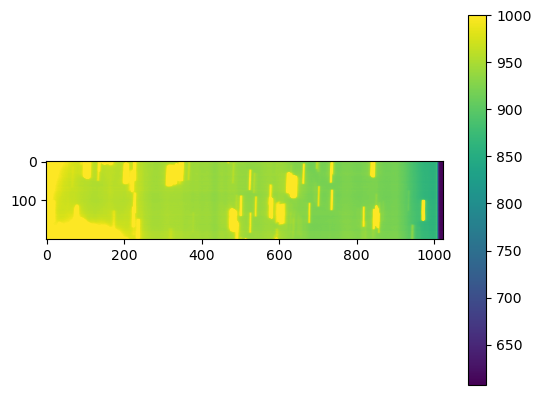

In [163]:
plt.imshow(np.mean(np.array(cube),axis=2),vmax=1000)
plt.colorbar()

In [197]:
np.shape(dark)

(1024, 1024)

In [199]:
plt.plot(wls,np.array(cube)[150,600,:-1]-dark[600,-1])

KeyError: (600, -1)

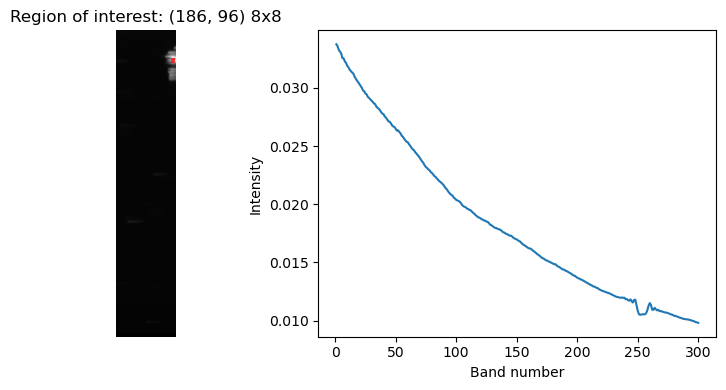

In [182]:
plot_roi(np.array(datacube)[:,:,200:500],i=190,j=100,box_width=8,n_bands=550-250)

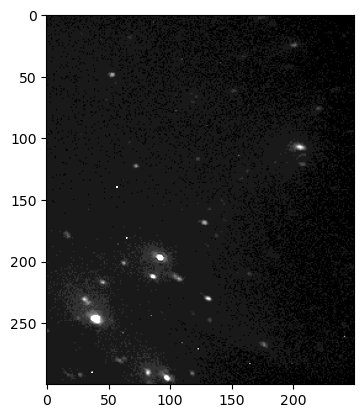

In [88]:
# check roi
roi = [700,1000,1250,1500]
f=all_fpaths[30]
im = np.array(Image.open(f).convert('L'))
# crop image
im = im[roi[0]:roi[1],roi[2]:roi[3]]

plt.imshow(im,vmax=25,cmap='gray')
#plt.colorbar()
#plt.axis('off')

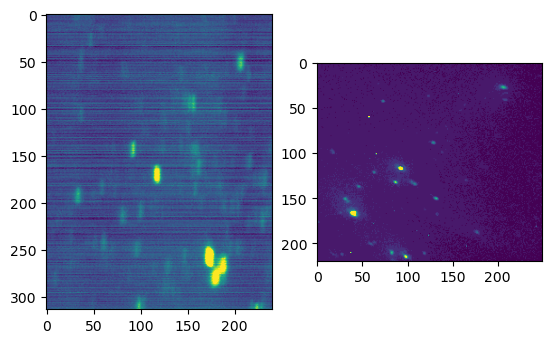

In [116]:
f,axs = plt.subplots(ncols=2)
x1=500
x2=750
axs[0].imshow(np.mean(np.array(cube)[:,500:740,:],axis=2),vmax=650)#,extent=[x1,x2,x1,x2])
axs[1].imshow(imcs[780:1000,1250:1500],vmax=30)

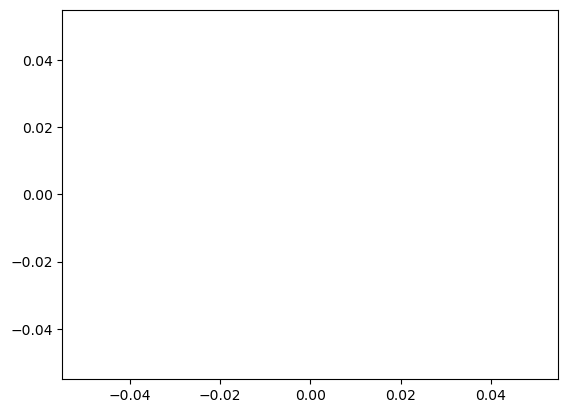

In [122]:
plt.plot((np.array(cube)[280,680,:]-dark.iloc[:,680])/(light.iloc[:,680]-light.iloc[:,680]))

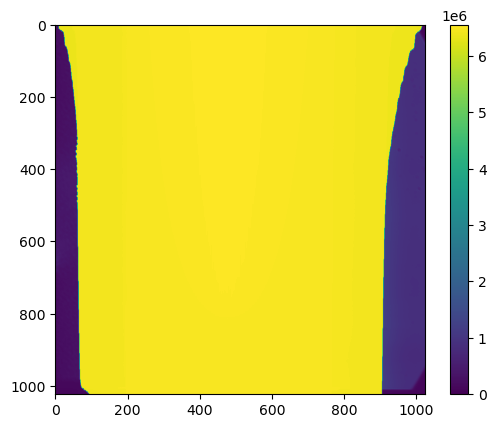

In [185]:
plt.imshow(light)
plt.colorbar()